# SC3000 Artificial Intelligence, Lab Group Z59, AY22/23

Team members
- Budi Syahiddin (U2120429A)
  - (development of q-learning, testing hyperparameters, formatting, testing)
- Faiz Rosli (U2121876J)
  - (development of q-learning, testing hyperparameters, formatting, testing)
- Chin Tao (U2121927G)
  - (development of q-learning, testing hyperparameters, formatting, testing)

## Installing dependencies:

In [21]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


Defaulting to user installation because normal site-packages is not writeable


The system cannot find the path specified.
The system cannot find the path specified.


Defaulting to user installation because normal site-packages is not writeable
  Using cached setuptools-67.6.0-py3-none-any.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.27 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.27 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.


The system cannot find the path specified.


## Importing dependencies and define helper functions

In [22]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [58]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [59]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [60]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [61]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.02595066 -0.02412082 -0.01844706 -0.01334705]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [62]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02546824 -0.21897343 -0.018714    0.273459  ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [63]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

## Chosen Solution
Q-Learning. Why? CartPole is a simple problem, does not have many states and there are only 2 possible actions! 
Also, Q-Learning is very easy to implement from first scratch and does not require a strong computer to train the agent.
Computing Q-Table state-action pair can be described using the equation below

$$
Q(s, a) = Q(s, a) + \alpha [R_{t+1} + \gamma \overbrace{\max_{a \in A(s_{t+1})}(Q(s_{t+1}, a))}^{\text{take best future action}} - Q(s,a))]
$$

## Chosen Policy
Epsilon Greedy. Why? Similar to the previous reason, it is simple to implement.

## Discretization
Q-Learning works well for environment with discrete states and actions.
However, CartPole states are continuous! In order to deal with that,
we will need to make the states discrete. The idea is to split the range
of the states into "bins", i.e. intervals. For example, if range is $[1, 10]$, and we let $N = 10$, then each interval is $1$.

## Decaying of $\alpha$ and Exploration Rate
Initially, we tested static $\alpha$ and exploration rate. While it worked after many episodes, the agent took too long to get good. For our decaying function, we chose the following implementation below, with $\text{let}\;y = \text{exploit episode} = 50$ and $\text{let}\;z = \text{episode no}$

$$
\text{Rate} = \max(0.01, \min(1, 1.0 - \log(\text{z} + 1 / y)))
$$

Make bins, i.e make intervals between lower and upper then divide them into $N$

In [29]:
def make_discrete(lower, upper, no_bins):
    return np.linspace(lower, upper, no_bins)

def generate_discrete_bins(no_bins=10, dims=4, no_actions=2):
    shape = [no_bins] * dims
    shape.append(no_actions)
    return np.zeros(shape=shape)

In [30]:
print(generate_discrete_bins().shape)

(10, 10, 10, 10, 2)


Init Q-Table utility

In [64]:
def generate_q_table(no_bins = 10):
    no_dbins = no_bins
    bins = np.array([
        make_discrete(-4.8, 4.8, no_dbins),
        make_discrete(-2.0, 2.0, no_dbins),  # original problem: -inf to inf
        make_discrete(-0.3, 0.3, no_dbins),  # -0.3 to 0.3 is good
        make_discrete(-2.0, 2.0, no_dbins),  # original problem: -inf to inf
    ])

    q = generate_discrete_bins(no_bins=no_dbins)

    return bins, q

Utility function to map $\mathbb R \mapsto \mathbb Z^+_0$

In [32]:
def round_toNearestBin(observation, bins):
    pos, vel, angle, angular_vel = observation
    pos_bin = np.digitize(pos, bins[0])
    pos_vel = np.digitize(vel, bins[1])
    pos_angle = np.digitize(angle, bins[2])
    pos_angular_vel = np.digitize(angular_vel, bins[3])

    # its 1 based, need -1
    return pos_bin - 1, pos_vel - 1, pos_angle - 1, pos_angular_vel - 1

Decaying variables

In [33]:
def learning_rate(episode_no: int, min_rate = 0.01) -> float:
    # need add 1 cos episode is 0 based
    return max(min_rate, min(1.0, 1.0 - math.log10((episode_no + 1) / 50)))

def discount_factor():
    return 0.995

def exploration_rate(episode_no: int, min_rate = 0.01) -> float:
    # need add 1 cos episode is 0 based
    return max(min_rate, min(1, 1.0 - math.log10((episode_no + 1) / 50)))


Epsilon Greedy Policy

In [34]:
def policy(q, observation, episode_no):
    action = np.argmax(q[observation])

    if np.random.random() < exploration_rate(episode_no):
        action = random.randint(0, 1)

    return action

Function to train Q-table

This function contains a few debugging print and ability to render the training if you want. The debugging only runs every 1000 episodes which keeps track the previous 1000 mean, the mean and number of episodes that have 500 score within that particular 1000 interval. You also have a choice to terminate when a certain percentage score is reached even if your episode is higher, 

In [51]:
def q_learning_trainer(episodes = 5000,
                       no_bins = 10,
                       run_limit=120000,
                       terminate_on_percentage_score = (False, 0.5)):
    print(f"init trainer with, episode = {episodes}, no_bins = {no_bins}")
    
    bins, qt = generate_q_table(no_bins=no_bins)

    print(f"Table shape: {qt.shape}")

    episode = 0
    avg = 0
    fullscore_episodes_in_interval = 0
    interval_avg = 0

    while episode < episodes and episode < run_limit:
        observation_discrete = round_toNearestBin(env.reset(), bins)
        done = False
        reward_episode = 0

        # keep stepping t+1 into the future until done
        # which happens when it fails
        while not done:                
            action = policy(qt, observation_discrete, episode_no=episode)
            new_obs, new_reward, done, _ = env.step(action)
            future_obs = round_toNearestBin(new_obs, bins)

            max_future = np.max(qt[future_obs])
            q_current = qt[observation_discrete][action]

            q_New = q_current + learning_rate(episode_no=episode) * \
                ((new_reward + discount_factor() * max_future) - q_current)

            # update q
            qt[observation_discrete][action] = q_New

            # update previous obs to new one 
            observation_discrete = future_obs

            # track episode rewards
            reward_episode += new_reward
            
        avg = ((avg * (episode)) + reward_episode) / (episode + 1)

        interval_avg += reward_episode

        if reward_episode == 500.0:
            fullscore_episodes_in_interval += 1
        
        if terminate_on_percentage_score[0] and fullscore_episodes_in_interval / 1000 >= terminate_on_percentage_score[1]:
            print("Found 500/10000 full scores. Terminating training!")
            break

        # print logs
        # reset interval avg and fullscore in interval
        if episode % 1000 == 0:
            if episode != 0:
                interval_avg /= 1000
            print(f"Evaluating episode: {episode}, episode_reward: {reward_episode}, avg_so_far: {avg}, interval_avg: {interval_avg}, explore_r: {exploration_rate(episode)}, 500_in_interval: {fullscore_episodes_in_interval}")
            fullscore_episodes_in_interval = 0
            interval_avg = 0
        
        episode += 1
  
    return qt, bins

Q-learning Agent

In [36]:
def q_learning_agent(qt, obs, bins):
    return np.argmax(qt[round_toNearestBin(obs, bins)])

For Task 1, we can show the observation and chosen action below:

In [52]:
q, bins = q_learning_trainer(episodes=5000, no_bins=10)

observation = env.reset()
action = q_learning_agent(q, observation, bins)
print("Observation:", observation)
print("Chosen action:", action)

init trainer with, episode = 5000, no_bins = 10, render_to_screen = False
Table shape: (10, 10, 10, 10, 2)
Running on google colab, turning on custom renderer
Evaluating episode: 0, episode_reward: 18.0, avg_so_far: 18.0, interval_avg: 18.0, explore_r: 1, 500_in_interval: 0
Evaluating episode: 1000, episode_reward: 162.0, avg_so_far: 117.13486513486511, interval_avg: 117.234, explore_r: 0.01, 500_in_interval: 2
Evaluating episode: 2000, episode_reward: 500.0, avg_so_far: 272.49575212393825, interval_avg: 428.012, explore_r: 0.01, 500_in_interval: 652
Evaluating episode: 3000, episode_reward: 500.0, avg_so_far: 334.80373208930325, interval_avg: 459.482, explore_r: 0.01, 500_in_interval: 740
Evaluating episode: 4000, episode_reward: 377.0, avg_so_far: 364.92701824543815, interval_avg: 455.327, explore_r: 0.01, 500_in_interval: 713
Observation: [-0.04430542  0.02041289 -0.00098104  0.03356306]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [56]:
def run_n_trained(qt, bins, render_to_screen = False, is_google_colab = False, n = 1):
    res = np.zeros(n)
    for i in range(n):
        observation = env.reset()
        ep_reward = 0    
        done = False
        while not done:
            if render_to_screen:
                env.render()
            #your agent goes here
            action = q_learning_agent(qt, observation, bins) 
            observation, reward, done, _= env.step(action)
            ep_reward += reward

        res[i] = ep_reward

    if render_to_screen:
        env.close()
        if is_google_colab:
            show_video()
    
    return res

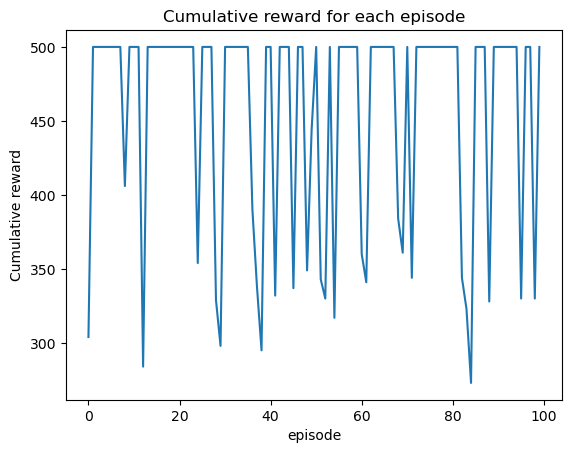

In [54]:
episode_results = run_n_trained(q, bins, n = 100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [55]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 456.68
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [57]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
run_n_trained(q, bins, render_to_screen=True, is_google_colab=True, n = 1)

array([500.])